# Проект: классификация

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='bright', font='serif', color_codes=True, 
              rc={'figure.figsize':(10,8), 'axes.titlesize':18,'axes.labelsize':16, 'font.family': 'Verdana', 'lines.linewidth': 2 })
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator
from sklearn.preprocessing  import OrdinalEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
import optuna
from functools import partial

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
print(df.shape)
df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


 проверка на NaN 

In [5]:
df.isnull().sum() 

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
# каст к числовому типу
display(df['balance'])
df['balance'] = df['balance'].apply(lambda row: str(row).split(',')[0].replace('$', '').replace(' ', '')).astype('float')
print('--'*16)
df['balance']


0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

--------------------------------


0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

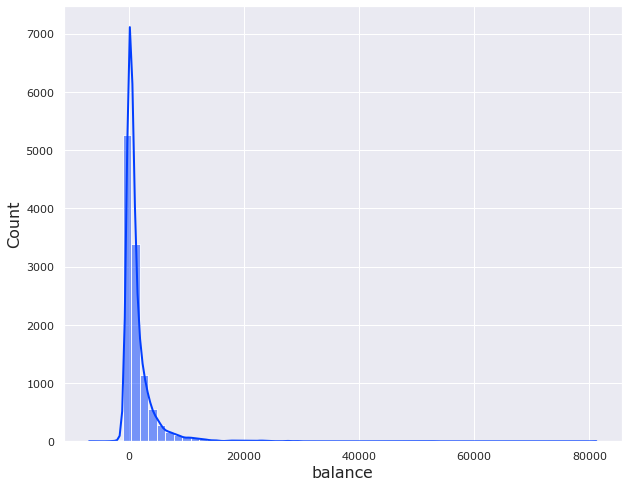

In [110]:
sns.histplot(df['balance'], bins=60, kde=True);

In [8]:
df['balance'].fillna(df['balance'].median(), inplace=True) # заполним медианой вследствие большого хвоста признака

In [9]:
# Также заполним немногочисленные неявные пропуски в job и education
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)
df['education'].replace('unknown', df['education'].mode()[0], inplace=True)

Попробуем убрать выбросы из признака balance по методу Тьюки с подобранными границами

In [10]:
df_tukey = df.copy()

In [11]:
def IQR_outlier(data, feature, lower_scale=1.5, upper_scale=1.5, log=False):
    if log:
        x = pd.Series(np.log(np.where(data[feature] >= 0, data[feature], 0) + 1))
    else:
        x = data[feature]
    q1 = x.quantile(0.25) 
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    print(q1 - lower_scale*iqr, q3 + upper_scale*iqr)
    return data[(x >= (q1 - lower_scale*iqr)) & (x <= (q3 + upper_scale*iqr))]
df_tukey = IQR_outlier(df_tukey, feature='balance', log=False) # поставить Log
df_tukey.shape

-2241.0 4063.0


(10105, 17)

## Часть 2:  Разведывательный анализ

Прежде всего сопоставим распределение меток целевого класса.

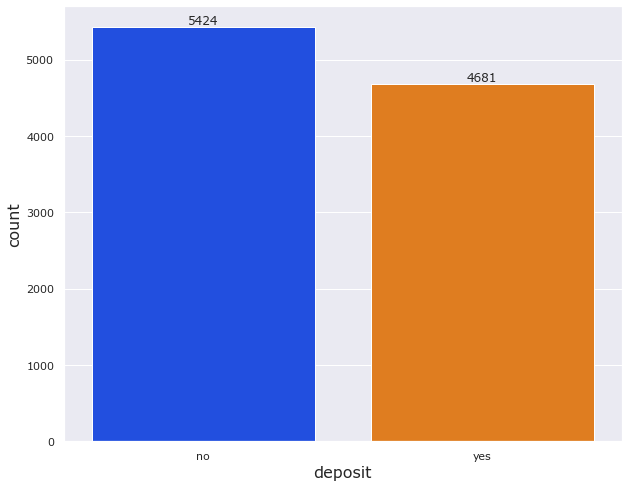

In [111]:
ax = sns.countplot(data=df_tukey, x='deposit', order=['no', 'yes'])
ax.bar_label(ax.containers[0]);

In [13]:
# sns.pairplot(data=df_tukey, diag_kind='kde', corner=True, plot_kws=dict(s=5, alpha=0.1)).map_lower(sns.kdeplot, levels=3, color=".2");

> Распределение 5 из 7 числовых признаков довольно ассиметрично с пиком в нуле. Также отчетливо видна обратная зависимость количества контактов текущей и прошедшей маркетинговых кампаний от продолжительности контакта (графики duration-compaign; duration-previous). Стоит еще отметить, что наибольшее число контактов с наибольшей продолжительностью удается устанавливать с клиентами возрастом от 25 до 50 лет (age-duration;compaign;previous).

In [14]:
df_tukey.describe(percentiles=[0.1, 0.5, 0.75, 0.9]) # описательные статистики количественных переменных

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
10%,28.000000,0.000000,4.000000,76.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
90%,57.000000,2395.200000,28.000000,832.000000,5.000000,193.000000,3.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


> Максимальное значение признака duration к удивлению велико, вполне ожидаема прямая зависимость вероятности открытия депозита от продолжительности контакта (ну или клиенты общаются с маркетологом около часа о жизни), минимальное же значение наводит на мысль, что контакты длиною менее минуты редко будут венчаться маркетинговым успехом. 
> 
> Скачок значений признака pdays после 0.75-го квантиля кажется аномальным, даже учитывая его ассиметричность. Также как минимум 10% клиентов имеют отрицательный баланс, исходя из житейской логики, они будут открывать депозит с меньшей вероятностью.
> 
> Стоит обратить внимание на признак количества контактов в рамках текущей комапании (`campaign`), у которого чересчур велико максимальное значение, учитывая что с 90% клиентов связывались не более 5 раз.

Разделим клиентов на возрастные подгруппы, преобразуя признак age

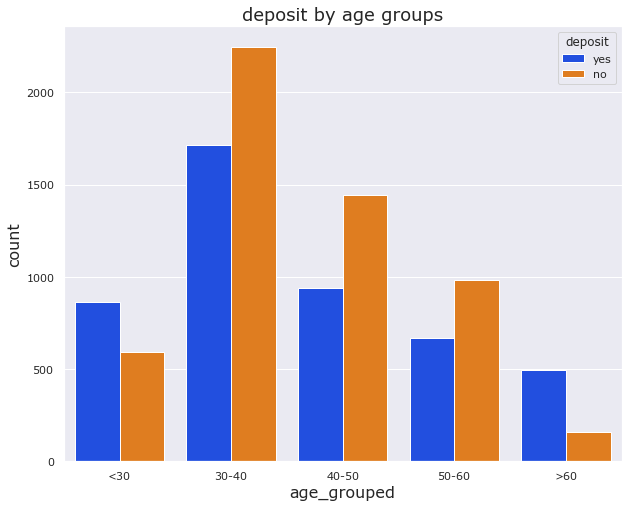

In [112]:
def age_grouping(sample):
    if sample < 30:
        return '<30'
    elif 30 <= sample < 40:
        return '30-40'
    elif 40 <= sample < 50:
        return '40-50'
    elif 50 <= sample < 60:
        return '50-60'
    else:
        return '>60'
df_tukey['age_grouped'] = df['age'].apply(age_grouping)
sns.countplot(data=df_tukey, x='age_grouped', order=['<30', '30-40', '40-50', '50-60', '>60'], hue='deposit').set(
    title='deposit by age groups');

> Интерес представляют группы клиентов моложе 30 и старше 60, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.

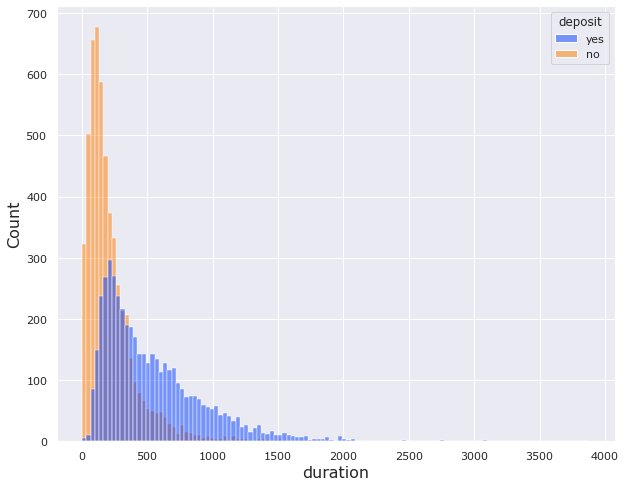

In [113]:
sns.histplot(data=df_tukey, x='duration', hue='deposit');

> Почти все контакты длиннее 11-12 минут завершались открытием депозита, а контакты короче 5 минут чаще всего проваливались.

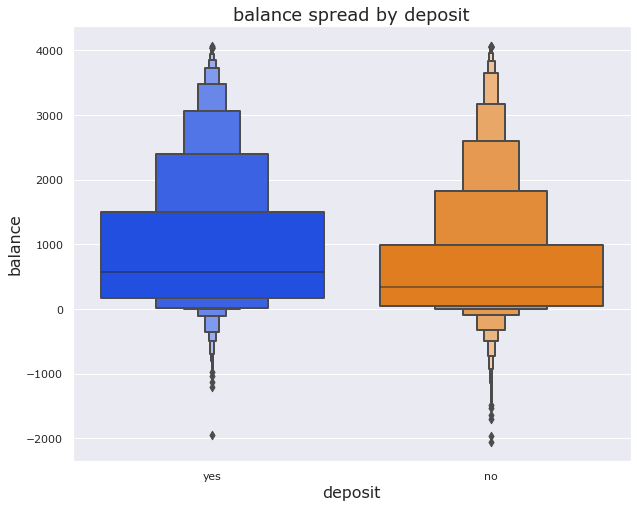

In [114]:
sns.boxenplot(data=df_tukey, x='deposit', y='balance').set(title='balance spread by deposit');

> Разброс баланса **основного**(внутри iqr) количества клиентов, открывших депозит больше, чем у неоткрывших, но в рамках общей картины баланс первых, выше.

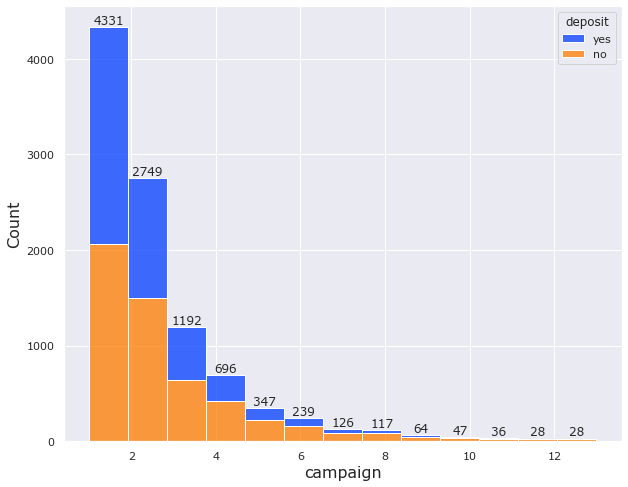

In [115]:
# возьмем для наглядности записи с небольшим относительно максимума количеством контактов 
ax = sns.histplot(data= df_tukey[df_tukey['campaign']<14], x='campaign', bins=13, hue='deposit', multiple="stack")
ax.bar_label(ax.containers[1]);

> Более 70% клиентов, открывших депозит общались с маркетологом 1-2 раза, также из графика явно видно, что связываться с одним клиентом больше 8 раз в рамках одной маркетинговой кампании почти не имеет смысла.

***

In [19]:
print("Описательные статистики категориальных переменных")
df_tukey.describe(include='object')

Описательные статистики категориальных переменных


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit,age_grouped
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2,5
top,management,married,secondary,no,no,no,cellular,may,unknown,no,30-40
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424,3961


> Отсюда можно заключить, что 98% клиентов из данной выборки не просрачивали кредиты; большинство контактов заключались по сотовой связи; и что приизнак результата прошедшей маркетинговой кампании (poutcome) довольно бесполезен вследствие 75% 'unknown' значений.

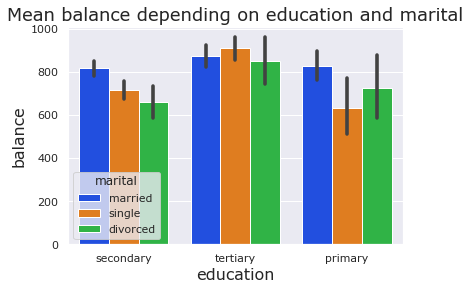

In [20]:
ax = sns.barplot(data=df_tukey, x='education', y='balance', hue='marital')
ax.set_title("Mean balance depending on education and marital");

> Вне зависимости от семейного положения, клиенты с высшим образованием в среднем имеют наибольший средний баланс на счету, что довольно ожидаемо. Однако максимум среднего баланса наблюдается именно у одиноких людей с высшим образованием

Посмотрим на значение целевого признака в разрезе категориальных признаков и времени.<br>
Для начала визуализируем пересечение категорий семейного положения и уровня образования.

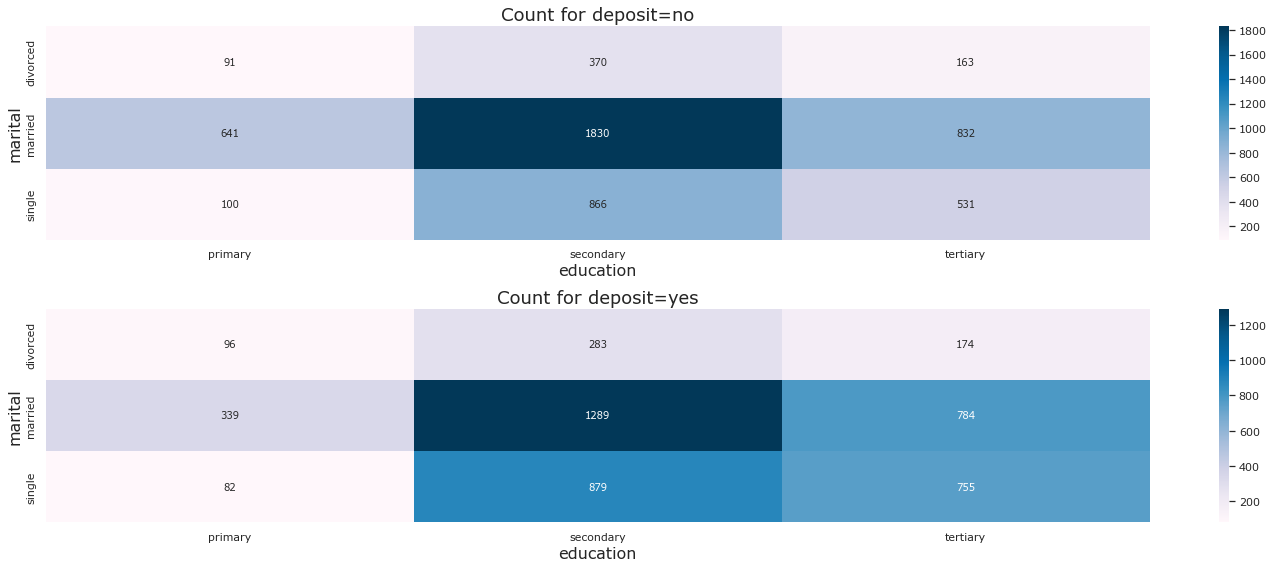

In [21]:
fig, axes = plt.subplots(2, figsize=(20,8))
deposits_list = ['no', 'yes']
for i in range(len(axes)):
    piv = pd.pivot_table(data=df_tukey[df_tukey['deposit']==deposits_list[i]], index='marital', columns='education', 
                                         values='deposit', aggfunc='count')
    sns.heatmap(data=piv, ax=axes[i], cmap='PuBu', annot=True, fmt='d').set(title=f'Count for deposit={deposits_list[i]}')
fig.tight_layout()

> Видно, что пересечение категорий `married-secondary` самое многочисленное в наших данных, однако тенденция к открытию депозита у клиентов с этой парой категорий отрицательная. А одинокие клиенты со средним и высшим образованием, напротив, чуть более склонны к открытию депозита (`single-secondary` и `single-tertiary`).

In [22]:
def month_convert(sample): # переделать
    match sample:
        case "jan":
            return 1
        case "feb":
            return 2
        case "mar":
            return 3
        case "apr":
            return 4
        case "may":
            return 5
        case "jun":
            return 6
        case "jul":
            return 7
        case "aug":
            return 8
        case "sep":
            return 9
        case "oct":
            return 10
        case "nov":
            return 11
        case "dec":
            return 12

df_tukey['month_num'] = df_tukey['month'].apply(month_convert).astype('int') # признак номера месяца
# df_tukey.drop('month',axis=1,inplace=True)

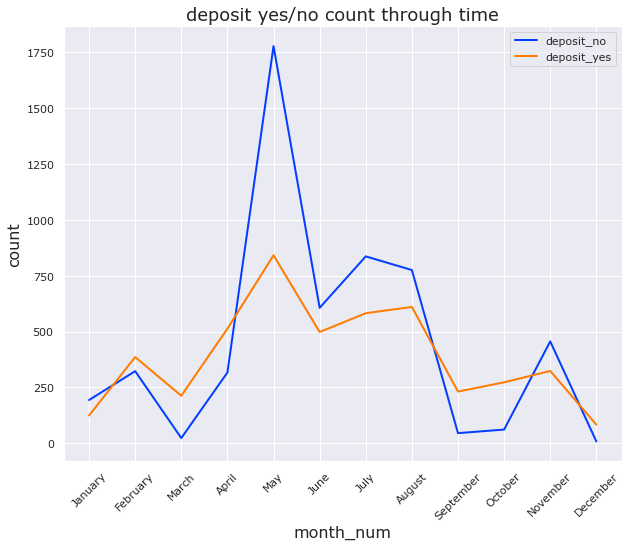

In [116]:
df_dep_month = df_tukey.groupby(['deposit','month_num'])['deposit'].count()
ax = sns.lineplot(data=df_dep_month['no'], label='deposit_no')
sns.lineplot(data=df_dep_month['yes'], label='deposit_yes')
ax.set_title("deposit yes/no count through time")
ax.set_ylabel('count')
ax.set_xticks(range(1,13), labels=pd.to_datetime(range(1,13), format='%m').month_name(), rotation=45);


> Самым неудачным и одновременно удачным месяцом для данной маркетинговой кампании оказался май, по графику можно заключить что наиболее активный период проведения кампании был второй квартал года (апрель, май, июнь).

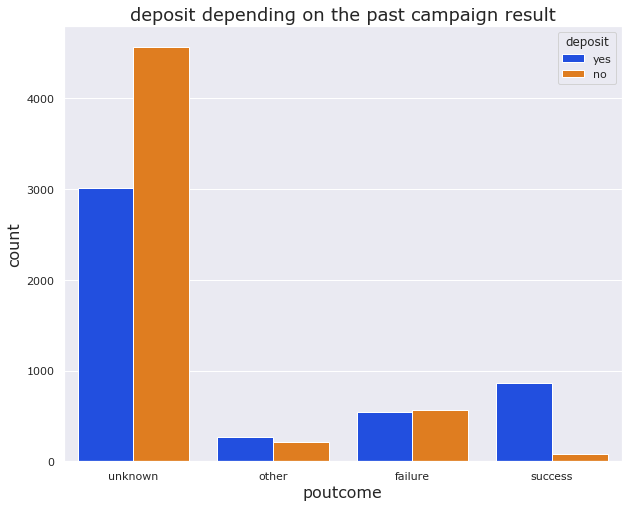

In [117]:
# piv = pd.pivot_table(data=df_tukey, index='deposit', columns='poutcome', values='balance', aggfunc='count')
sns.countplot(data=df_tukey, x='poutcome', hue='deposit').set(title='deposit depending on the past campaign result');

> Как и было сказано выше, признак результатов предыдущей маркетинговой кампании довольно неинформативный из-за большого количества пропусков, но тем не менее почти все успехи предыдущей кампании повторились и в текущей.

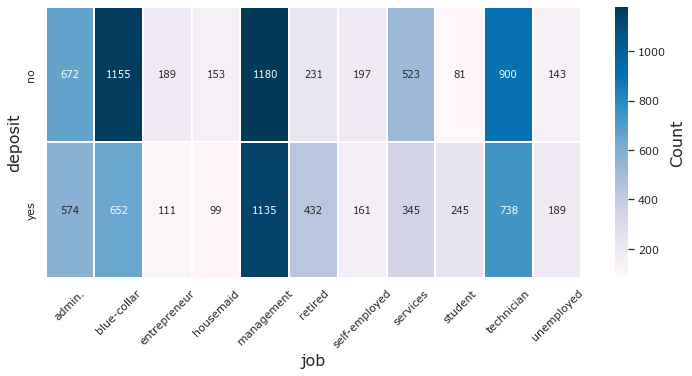

In [25]:
plt.figure(figsize=(12,5))
deposit_by_job = pd.pivot_table(df_tukey, index='deposit', columns='job', values='balance', aggfunc='count')
sns.heatmap(deposit_by_job, cmap='PuBu', linewidths=2, annot=True, fmt='d', cbar_kws={'label': 'Count'}).xaxis.set_tick_params(rotation=45)

>Клиентов, занятых в сфере менеджмента в данных больше всего, как было показано выше в описательных статистиках, они, суля по данным с равной вероятностью соглашаются и отказываются от предложения. Клиенты, занимающиеся физическим трудом (`blue-collar`) склонны отклонять предложения в рамках маркетинговой кампании. Интерес представляют группа ушедших в отставку или на пенсию клиентов `retired`, которые чаще открывают депозиты.

***

## Часть 3: преобразование данных

In [26]:
df_encoded = df_tukey.copy()

Начнем с порядкового кодирования соответствующих признаков и а бинарные признаки, включая целевой приведем к числовому виду

In [27]:
le = OrdinalEncoder()
ord_enc_cols = ['education', 'age_grouped']
binary_cols = ['loan', 'housing', 'default', 'deposit']
df_encoded[ord_enc_cols] = le.fit_transform(df_encoded[ord_enc_cols])
for col in binary_cols:
    df_encoded[col] = df_encoded[col].apply(lambda value: 1 if  value == 'yes' else 0)

One-hot кодирование для номинальных признаков

In [28]:
one_hot_cols = ['job', 'marital', 'contact', 'month', 'poutcome'] 
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols)

Проверим признаки на корреляционную связь, сначала с целевой переменной

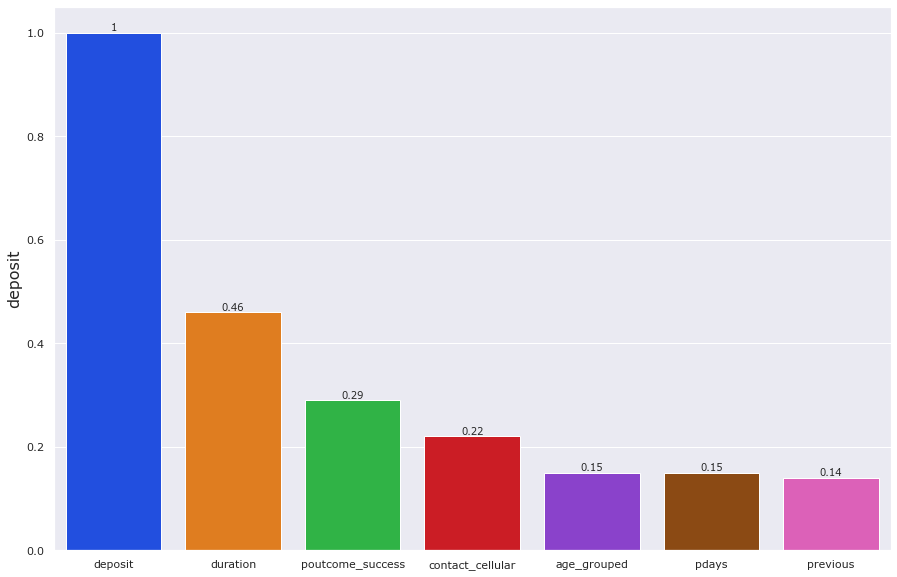

In [29]:
corr_with_target = pd.DataFrame(round(df_encoded.corr()['deposit'].sort_values(ascending=False).nlargest(7),2))
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(data=corr_with_target, x=corr_with_target.index, y=corr_with_target['deposit'])
ax.bar_label(ax.containers[0]);

> Сильной линейной зависимости между целевой переменной и предикторами нет.

##### Так как признаков из-за One-Hot кодирования получилось почти 50, матрица корреляций будет нечитабельна в принципе. Поэтому реализуем нахождения пар признаков, модуль коэффицента корреляции между которыми больше 0.5 следующим образом:

In [30]:
corr_features_pairs = []
corr_values = []
corr_matrix = df_encoded.corr()
for col in corr_matrix:
    tuples = list(corr_matrix[col].items())
    for value in tuples:
        if value[0] != col and (value[1] > 0.5 or value[1] < -0.5):
            if value[0] + '-' + col not in corr_features_pairs:
                corr_features_pairs.append(col + '-' + value[0])
                corr_values.append(abs(value[1]))

И здесь же для удобства визуализируем получившиеся пары и значения коэф. корреляции

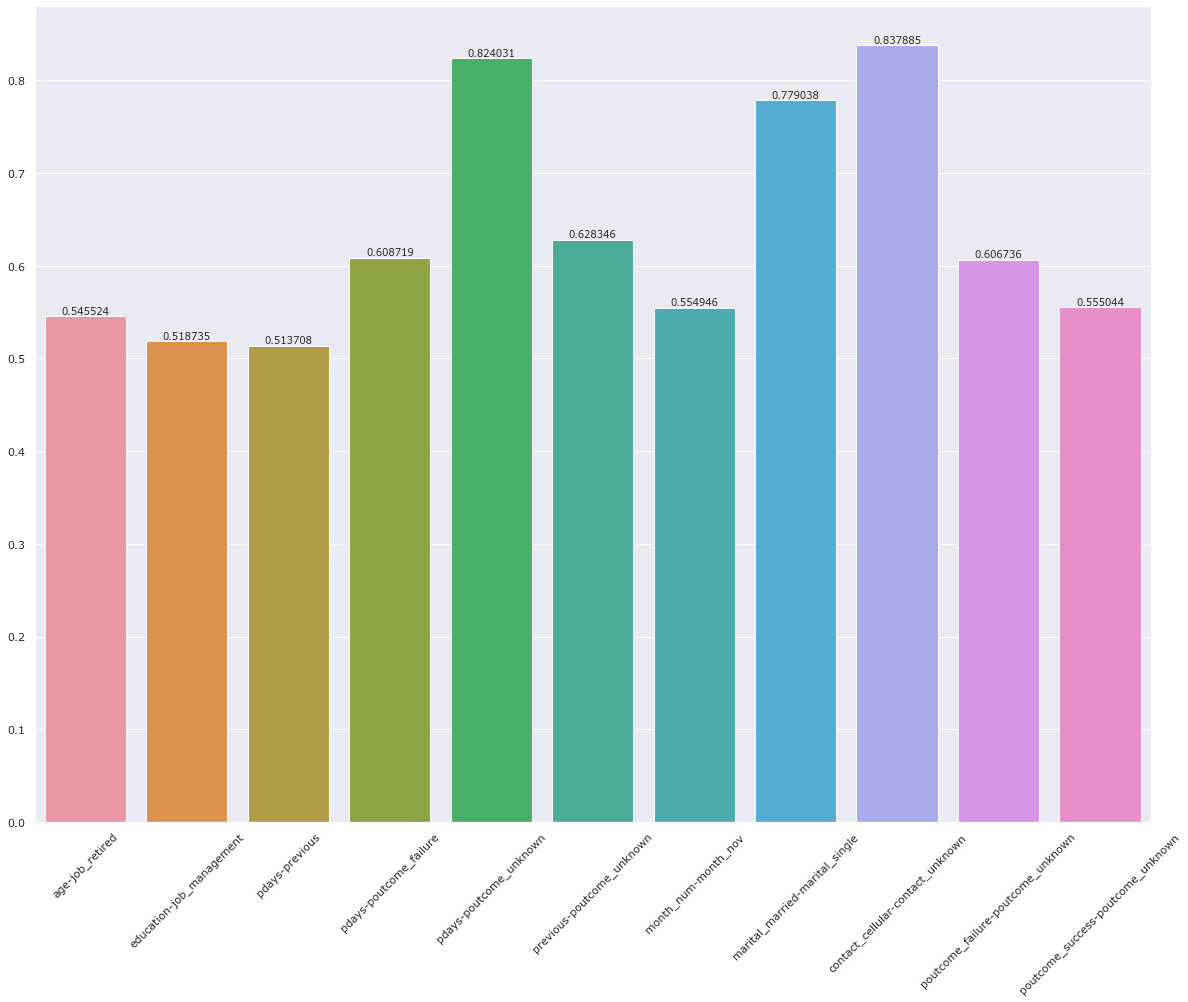

In [31]:
plt.figure(figsize=(20,15))
ax = sns.barplot(x=corr_features_pairs, y=corr_values)
ax.xaxis.set_tick_params(rotation=45)
ax.bar_label(ax.containers[0]);

> Максимальная линейная связь в данных прослеживается между двумя парами признаков: `pdays` - `poutcome_unknown` и `contact_cellular` - `contact_unknown`. Удалим признаки с меткой `uknown`.

## !!!!

In [32]:
df_encoded.drop(['poutcome_unknown', 'contact_unknown'], axis=1, inplace=True)

***

Разделим данные и оставим для последующего обучения модели 15 признаков с помощью селектора `SelectKBest` cо статистическим критерием ANOVA

In [33]:
X = df_encoded.drop(['deposit'], axis=1)
y = df_encoded['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [34]:
skb = SelectKBest(score_func=f_classif, k=15)
X_train_selected = skb.fit_transform(X_train, y_train)
X_test_selected = skb.transform(X_test)

In [35]:
X_train_selected.shape

(6770, 15)

Визуализируем признаки, отобранные селектором и их score по дисперсионному анализу ANOVA

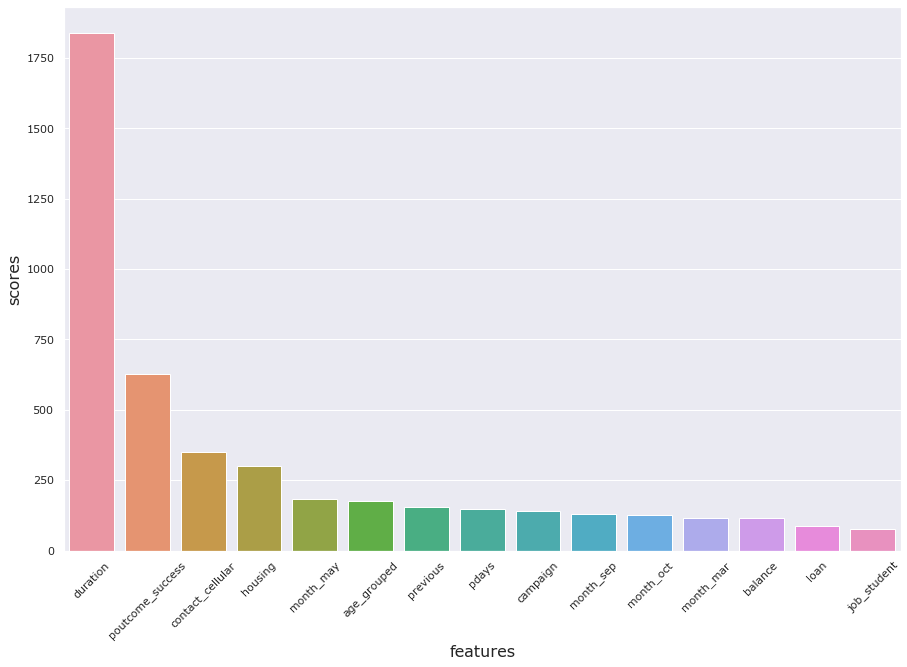

In [36]:
feature_scores = pd.DataFrame({'features':skb.feature_names_in_, 'scores': skb.scores_ }).sort_values(
    by='scores', ascending=False).nlargest(15, columns='scores')
plt.figure(figsize=(15,10))
sns.barplot(data=feature_scores, x='features', y='scores').xaxis.set_tick_params(rotation=45)

Нормализуем данные при помощи MinMaxScaler

In [37]:
mm_scaler = MinMaxScaler()
X_train_selected = mm_scaler.fit_transform(X_train_selected)
X_test_selected = mm_scaler.transform(X_test_selected)

In [38]:
X_test_selected[:,0].mean()

0.46823674223097866

# Часть 4: Логистическая регрессия и решающие деревья

In [39]:
R_STATE = 42
def get_classification_report(model, X_test=X_test_selected, y_true=y_test):
    print(metrics.classification_report(model.predict(X_test), y_true))

Так как неизвестны приоритеты банка: количество клиентов, которые вероятнее всего откроют депозит или точность в их определении, о качестве моделей будем судить по среднему гармончискому между этими аспектами (`f1-score`). В качестве baseline обучим:
* Логистическую регрессию

In [40]:
log_reg = linear_model.LogisticRegression(random_state=R_STATE, max_iter=1000)
log_reg.fit(X_train_selected, y_train)
print("Logistic regression results:")
get_classification_report(log_reg)

Logistic regression results:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1931
           1       0.75      0.82      0.78      1404

    accuracy                           0.81      3335
   macro avg       0.80      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



* И дерево решений с полным перебором небольшого диапозона основных дискретных гиперпараметров с кросс-валидацией

In [41]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5,6,7,10],
    'min_samples_split': [2,3,5,7,10],
    'min_samples_leaf': [2,3,5,7]
}
gsCV = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=R_STATE),
                    param_grid=param_grid,
                    cv=5)
gsCV.fit(X_train_selected, y_train)
gs_dtree = gsCV.best_estimator_
gsCV.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 2}

In [42]:
get_classification_report(gsCV)

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1777
           1       0.80      0.80      0.80      1558

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



В целом, как базовая лог. регрессия, так и решающее дерево дали неплохие результаты с `f1-score` ≈ 0.80. Также заметим, что модели более удачно справляются с определением нулевого класса.

***

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Обучим для начала **случайный лес** с базовыми параметрами, за исключением максимальной глубины и минимального количества сэмплов в листовой вершине во избежании переобучения.

In [43]:
rf_model = ensemble.RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=R_STATE)
rf_model.fit(X_train_selected, y_train)
get_classification_report(rf_model)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1720
           1       0.84      0.80      0.82      1615

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Качество предсказания выросло совсем немного, но данная модель более интересна возможностью оценить важность признаков, использованных при ее обучении (как и решающее дерево, но RForest дает, очевидно, более точно значение важности): 

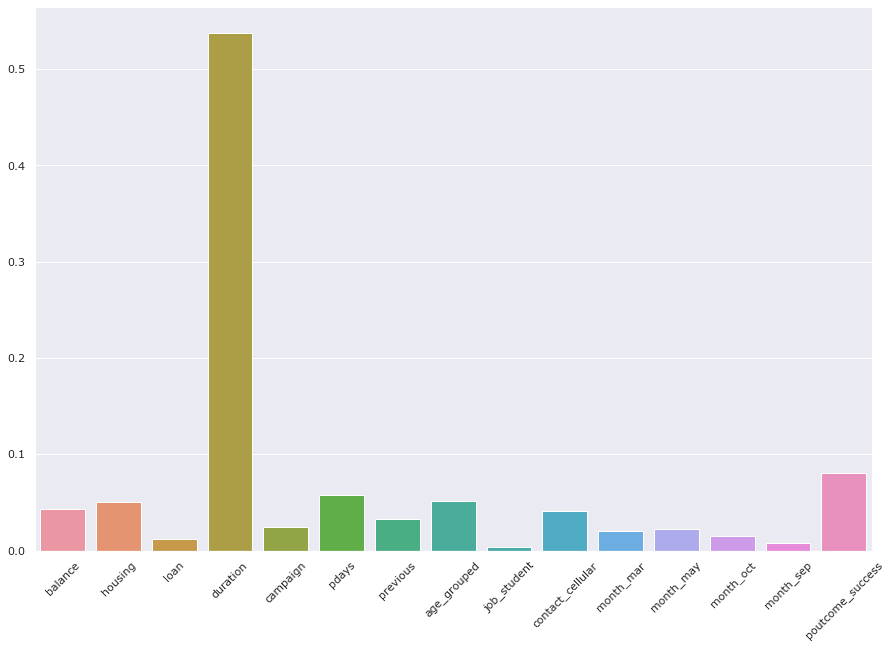

In [44]:
plt.figure(figsize=(15,10))
sns.barplot(x=skb.get_feature_names_out(), y=rf_model.feature_importances_).xaxis.set_tick_params(rotation=45);

Результат в общих чертах согласается с выдвинутыми предположениями на стадии разведывательного анализа насчёт зависимости успеха от продолжительности контакта и результата предыдущей кампании.

***

Применим также модель градиентного бустинга с параметрами подобранными "на глаз"

In [45]:
GBmodel = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
GBmodel.fit(X_train_selected, y_train)
get_classification_report(GBmodel)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1737
           1       0.83      0.80      0.82      1598

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### А сейчас конкретный заеб с реализацией стекинга и байесовской оптимизаций гиперпараметров с помощью фреймворка Optuna

Score-функции для оптимизации Optuna

In [69]:
def rf_objective(trial, model, X, y, cv=5):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300, 50),
        "max_depth" : trial.suggest_int("max_depth", 10, 30, 2),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5, log=True),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.01, 1.0, log=True)  
    }
    f1_score = cross_val_score(model(**rf_params), X, y, scoring="f1", cv=cv).mean()
    return f1_score

def ab_objective(trial, model, X, y, cv=5):
    ab_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 5.0, log=True),
        
    }
    f1_score = cross_val_score(model(**ab_params), X, y, scoring="f1", cv=cv).mean()
    return f1_score

def gb_objective(trial, model, X, y, cv=5):
    gb_params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.8, log=True),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.9),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }
    f1_score = cross_val_score(model(**gb_params), X, y, scoring="f1", cv=cv).mean()
    return f1_score

In [70]:
def hyper_optimizer(X, y,estimator: tuple[str,BaseEstimator], objective_dict,  n_trials):
    """
    Функция оптимизирующая параметры базовой модели.
        estimator-кортеж названия модели и класса ее реализующего
        X-обучающий набор
        y-вектор ответов
        n_trials-количество итераций подбора гиперпараметров
    """
    # определим score-функцию для конкретной переданной модели
    objective = objective_dict[estimator[0]]
    objective = partial(objective, model=estimator[1], X=X, y=y)
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=R_STATE))
    study.optimize(func=objective, n_trials=n_trials) 
    return study.best_params

In [90]:
class StackingClassifer():
    """ Класс, реализующий алгоритм стекинга на всем обучающем наборе с кросс-валидацией
    """
    def __init__(self, estimators: list[tuple[str,BaseEstimator]], meta_model:BaseEstimator):
        self.estimators = estimators
        self.meta_model = meta_model
        self.meta_features = None
    def fit(self, X, y, objective_dict, cv=5, n_trials=10,  verbose=True):
        """
        X-обучающий набор,
        y-вектор ответов,
        objective_dict словарь {название модели: score-функция для ее оптимизации}
        cv-количество фолдов кросс-валидации,
        n_trials-количество итераций подбора гиперпараметров,
        verbose-логгинг
        """
        # Инициализация данных с мета-признаками
        self.meta_features = pd.DataFrame()
        self.estimators_fitted = []
        for estimator in self.estimators:
            if verbose:
                print(f"Оптимизация алгоритма {estimator[0]}...")
            # Оптимизируем гиперпараметры алгоритма
            params = hyper_optimizer(X, y, estimator, objective_dict, n_trials)
            if verbose:
                print(f"Алгоритм оптимизирован, лучшие параметры: {params}")
            # out-of-band прогнозы на фолдах для последующего обучения метамодели
            self.meta_features[f'{estimator[0]} preds'] = cross_val_predict(
                estimator[1](**params, random_state=R_STATE), X, y, cv=cv, method='predict_proba')[:,1]
            # непосредственно обучение самого алгоритма и добавление в общий список
            self.estimators_fitted.append((estimator[0], estimator[1](**params, random_state=R_STATE).fit(X,y)))
            if verbose:
                print(f"Алгоритм {estimator[0]} обучен")
        if verbose:
            print("Обучение мета-модели...")
        self.meta_model.fit(self.meta_features, y)
        if verbose:
            print(f"Мета-модель обучена")
    def predict(self, X, y=None):
        pred_meta = pd.DataFrame()
        for estimator in self.estimators_fitted:
            pred_meta[f'{estimator[0]} preds'] = estimator[1].predict_proba(X)[:,1]
        answer = self.meta_model.predict(pred_meta)
        return answer

In [104]:
estimators = [
    ('rf', ensemble.RandomForestClassifier),
    ('ab', ensemble.AdaBoostClassifier),
    ('gb', ensemble.GradientBoostingClassifier),
    ]   
objective_dict = {
    'rf': rf_objective,
    'ab': ab_objective,
    'gb': gb_objective
}

In [103]:
my_stack = StackingClassifer(estimators, meta_model=linear_model.LogisticRegression())

In [105]:
my_stack.fit(X_train_selected, y_train, objective_dict)

[I 2023-07-23 23:46:12,911] A new study created in memory with name: no-name-8e757b72-3777-454b-a055-e1e358c84f2c


Оптимизация алгоритма rf...


[I 2023-07-23 23:46:16,931] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 150, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'ccp_alpha': 0.5399484409787431}. Best is trial 0 with value: 0.0.
[I 2023-07-23 23:46:22,603] Trial 1 finished with value: 0.7667382996925356 and parameters: {'n_estimators': 250, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'ccp_alpha': 0.023270677083837805}. Best is trial 1 with value: 0.7667382996925356.
[I 2023-07-23 23:46:27,536] Trial 2 finished with value: 0.672710078885306 and parameters: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'ccp_alpha': 0.05404103854647329}. Best is trial 1 with value: 0.7667382996925356.
[I 2023-07-23 23:46:42,635] Trial 3 finished with value: 0.7431923134042857 and parameters: {'n_estimators': 200, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 2

Алгоритм оптимизирован, лучшие параметры: {'n_estimators': 100, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'ccp_alpha': 0.017050539260269296}


[I 2023-07-23 23:47:12,834] A new study created in memory with name: no-name-a6b41ea9-52d9-4228-b4ad-38e31da5fc5d


Алгоритм rf обучен
Оптимизация алгоритма ab...


[I 2023-07-23 23:47:17,344] Trial 0 finished with value: 0.6778036457791348 and parameters: {'n_estimators': 218, 'learning_rate': 4.123206532618725}. Best is trial 0 with value: 0.6778036457791348.
[I 2023-07-23 23:47:24,803] Trial 1 finished with value: 0.8027855291303769 and parameters: {'n_estimators': 380, 'learning_rate': 1.0401663679887312}. Best is trial 1 with value: 0.8027855291303769.
[I 2023-07-23 23:47:27,262] Trial 2 finished with value: 0.8072248610157544 and parameters: {'n_estimators': 120, 'learning_rate': 0.18408992080552522}. Best is trial 2 with value: 0.8072248610157544.
[I 2023-07-23 23:47:28,760] Trial 3 finished with value: 0.6778036457791348 and parameters: {'n_estimators': 76, 'learning_rate': 2.962151658830348}. Best is trial 2 with value: 0.8072248610157544.
[I 2023-07-23 23:47:34,816] Trial 4 finished with value: 0.7989496231446389 and parameters: {'n_estimators': 321, 'learning_rate': 1.5958573588141267}. Best is trial 2 with value: 0.8072248610157544.
[I

Алгоритм оптимизирован, лучшие параметры: {'n_estimators': 244, 'learning_rate': 0.31245650712608714}


[I 2023-07-23 23:48:01,062] A new study created in memory with name: no-name-6ccc44b9-dd35-414b-adde-7e5e09f94787


Алгоритм ab обучен
Оптимизация алгоритма gb...


[I 2023-07-23 23:48:07,790] Trial 0 finished with value: 0.796083655058044 and parameters: {'max_depth': 4, 'n_estimators': 478, 'learning_rate': 0.3318346462540576, 'subsample': 0.659195090518222, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.796083655058044.
[I 2023-07-23 23:48:18,864] Trial 1 finished with value: 0.6084369270623794 and parameters: {'max_depth': 9, 'n_estimators': 321, 'learning_rate': 0.3067683926740108, 'subsample': 0.31235069657748143, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.796083655058044.
[I 2023-07-23 23:48:21,195] Trial 2 finished with value: 0.8196203129227937 and parameters: {'max_depth': 2, 'n_estimators': 132, 'learning_rate': 0.08146314642362987, 'subsample': 0.6148538589793427, 'max_features': None}. Best is trial 2 with value: 0.8196203129227937.
[I 2023-07-23 23:48:22,908] Trial 3 finished with value: 0.8214838216134861 and parameters: {'max_depth': 2, 'n_estimators': 181, 'learning_rate': 0.09989454841666953, 'subsample': 0.57

Алгоритм оптимизирован, лучшие параметры: {'max_depth': 2, 'n_estimators': 181, 'learning_rate': 0.09989454841666953, 'subsample': 0.5736419905302216, 'max_features': 'sqrt'}
Алгоритм gb обучен
Обучение мета-модели...
Мета-модель обучена


In [106]:
my_stack_preds = my_stack.predict(X_test_selected)

In [108]:
get_classification_report(my_stack)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1808
           1       0.80      0.81      0.81      1527

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [86]:
best_params = study.best_trial.user_attrs['all_params']
estimators = [
    ('lr', ensemble.AdaBoostClassifier(**best_params['ada'], random_state=R_STATE)),
    ('rf', ensemble.RandomForestClassifier(**best_params['rf'], random_state=R_STATE)),
    ('gb', ensemble.GradientBoostingClassifier(**best_params['gb'], random_state=R_STATE)),
    ]   
stacking_model = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=R_STATE)
)
stacking_model.fit(X_train_selected,y_train)
get_classification_report(stacking_model)

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1804
           1       0.81      0.81      0.81      1531

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

